# Subject patterns with Spark

In this notebook we look at a large CSV file containing subject headings from MARC records.  Our goal is to process a file containing over eight million rows; because of this size, Spark might handle the volume more efficiently than R or Python, the other tools I would normally reach for when summarizing CSV data.

We begin by noting first that this is a PySpark notebook (if you're executing this in Jupyter, look for "pySpark" in the top right corner), not an ordinary Python notebook.  With a PySpark notebook, the ```pyspark``` command is executed in the background, giving you a SparkContext to work with (see [Spark programming guide](http://spark.apache.org/docs/latest/programming-guide.html) for details).

Let's verify that it all started correctly by checking that we have that SparkContext object available, which should present as ```sc```:

In [1]:
sc

Great, we're good to go.  Now let's take a look at the data.  See the ```README``` in this directory for background on how we generated the CSV file we'll work with here.

In [3]:
!ls -lh combined.csv

-rw-r--r--  1 dchud  EAD\Domain Users   191M Oct 26 11:48 combined.csv


In [4]:
!wc combined.csv

 8357060 14869531 199769397 combined.csv


Okay, that's a pretty big file:  191M of uncompressed CSV, representing 8,357,060 individual subjects across all the MARC records we started from.  In case you're wondering, here's what a few subjects look like:

In [8]:
!head combined.csv

bibid,tag,i1,i2,subfields,sf2











It might be obvious from the header row, but we're looking at record identifiers, the two indicators, all of the subfields present in the subject represented as a single string (e.g. "ay0" means subfields a, y, and 0 are present with values), and the value of subfield 2.  You might notice that the bibid values repeat; in this case we are looking at three different subjects for bibid 2164503, four for 2164506, and two for 2164508.  Perfectly normal.

We can start to explore this data with Spark as-is, but let's create a smaller sample set just so we can get our logic right first.

In [9]:
!gshuf -n 100000 -o sample.csv combined.csv

In [10]:
!wc sample.csv

  100000  177951 2389764 sample.csv


In [11]:
!head sample.csv

Looks good, but we lost our record ordering - not a big deal, but it might be helpful to get them back in order.  [csvkit's csvsort](http://csvkit.readthedocs.org/en/0.9.1/tutorial/2_examining_the_data.html#csvsort-order-matters) can help with that:

In [15]:
!csvsort --no-header-row -c1 sample.csv > sample-sorted.csv

In [16]:
!head sample-sorted.csv

column1,column2,column3,column4,column5,column6
2091965,650,,7,a20,fast
2091974,650,,7,a20,fast
2091975,650,,0,a0,
2091975,650,0,7,a02,gnd
2091996,600,1,0,adx,
2092000,650,0,7,a2,swd
2092005,650,,4,a,
2092030,650,,0,azv0,
2092040,650,,7,ax20,fast


We can confirm that our sample has at least some examples of multiple subjects per record, then, by noting that bibid 2091975 appears twice.  Good enough for now - the sorting won't matter to Spark, which will be counting in parallel anyway, but it's reassuring that our sample is useful.


## Loading the CSV into an RDD and counting

Let's load our sample data into an RDD and pull up some basic counts.

In [65]:
subjects_sample = sc.textFile("sample.csv")

And verify that the data loaded correctly:

In [66]:
subjects_sample.count()

100000

Looks good.  Let's split the data up now, and start to count things up.  First we have to parse the CSV structure, then we pull out the tag (index position 1) and put that into a tuple with the value 1.

In [67]:
tag_pairs = subjects_sample.map(lambda l: l.split(",")).map(lambda l: (l[1], 1))

Now we have a long list of tuples like ```[('650', 1), ('651', 1), ('650', 1), ...]```.  We structure the data this way because that makes it easy to run this next step, adding it all up, using the [Python operator "add"](https://docs.python.org/2/library/operator.html#operator.add) within the ```reduceByKey``` method.  We pipe that result into ```takeOrdered``` to get a sorted list of tags by count.  Note that we use ```-v``` for a descending count.

In [69]:
from operator import add
tag_counts = tag_pairs.reduceByKey(add).takeOrdered(25, key=lambda (k, v): -v)
tag_counts

[(u'650', 66131),
 (u'651', 13067),
 (u'600', 6330),
 (u'655', 5630),
 (u'653', 3700),
 (u'648', 2430),
 (u'610', 1647),
 (u'630', 638),
 (u'611', 424),
 (u'654', 2),
 (u'658', 1)]

Let's turn that into a function that we can use for the whole dataset.

In [70]:
def count_tags(subjects_rdd):
    pairs = subjects_rdd.map(lambda l: l.split(',')).map(lambda l: (l[1], 1))
    return pairs.reduceByKey(add).takeOrdered(25, key=lambda (k, v): -v)                                                        

Now getting the count across all the data is just a matter of loading the full set in and passing it to the function.

In [73]:
subjects_all = sc.textFile("combined.csv")
%time count_tags(subjects_all)

CPU times: user 20.8 ms, sys: 13.9 ms, total: 34.7 ms
Wall time: 33.2 s


[(u'650', 5533067),
 (u'651', 1081743),
 (u'600', 531846),
 (u'655', 460059),
 (u'653', 315902),
 (u'648', 202608),
 (u'610', 141059),
 (u'630', 54229),
 (u'611', 36314),
 (u'654', 176),
 (u'662', 36),
 (u'658', 15),
 (u'657', 4),
 (u'656', 1),
 (u'tag', 1)]

## What exactly did Spark just do?

One of the things I like most about Spark is its web UI, which offers lots of insight about how jobs get processed. Even a counting process as simple as this yields interesting results.

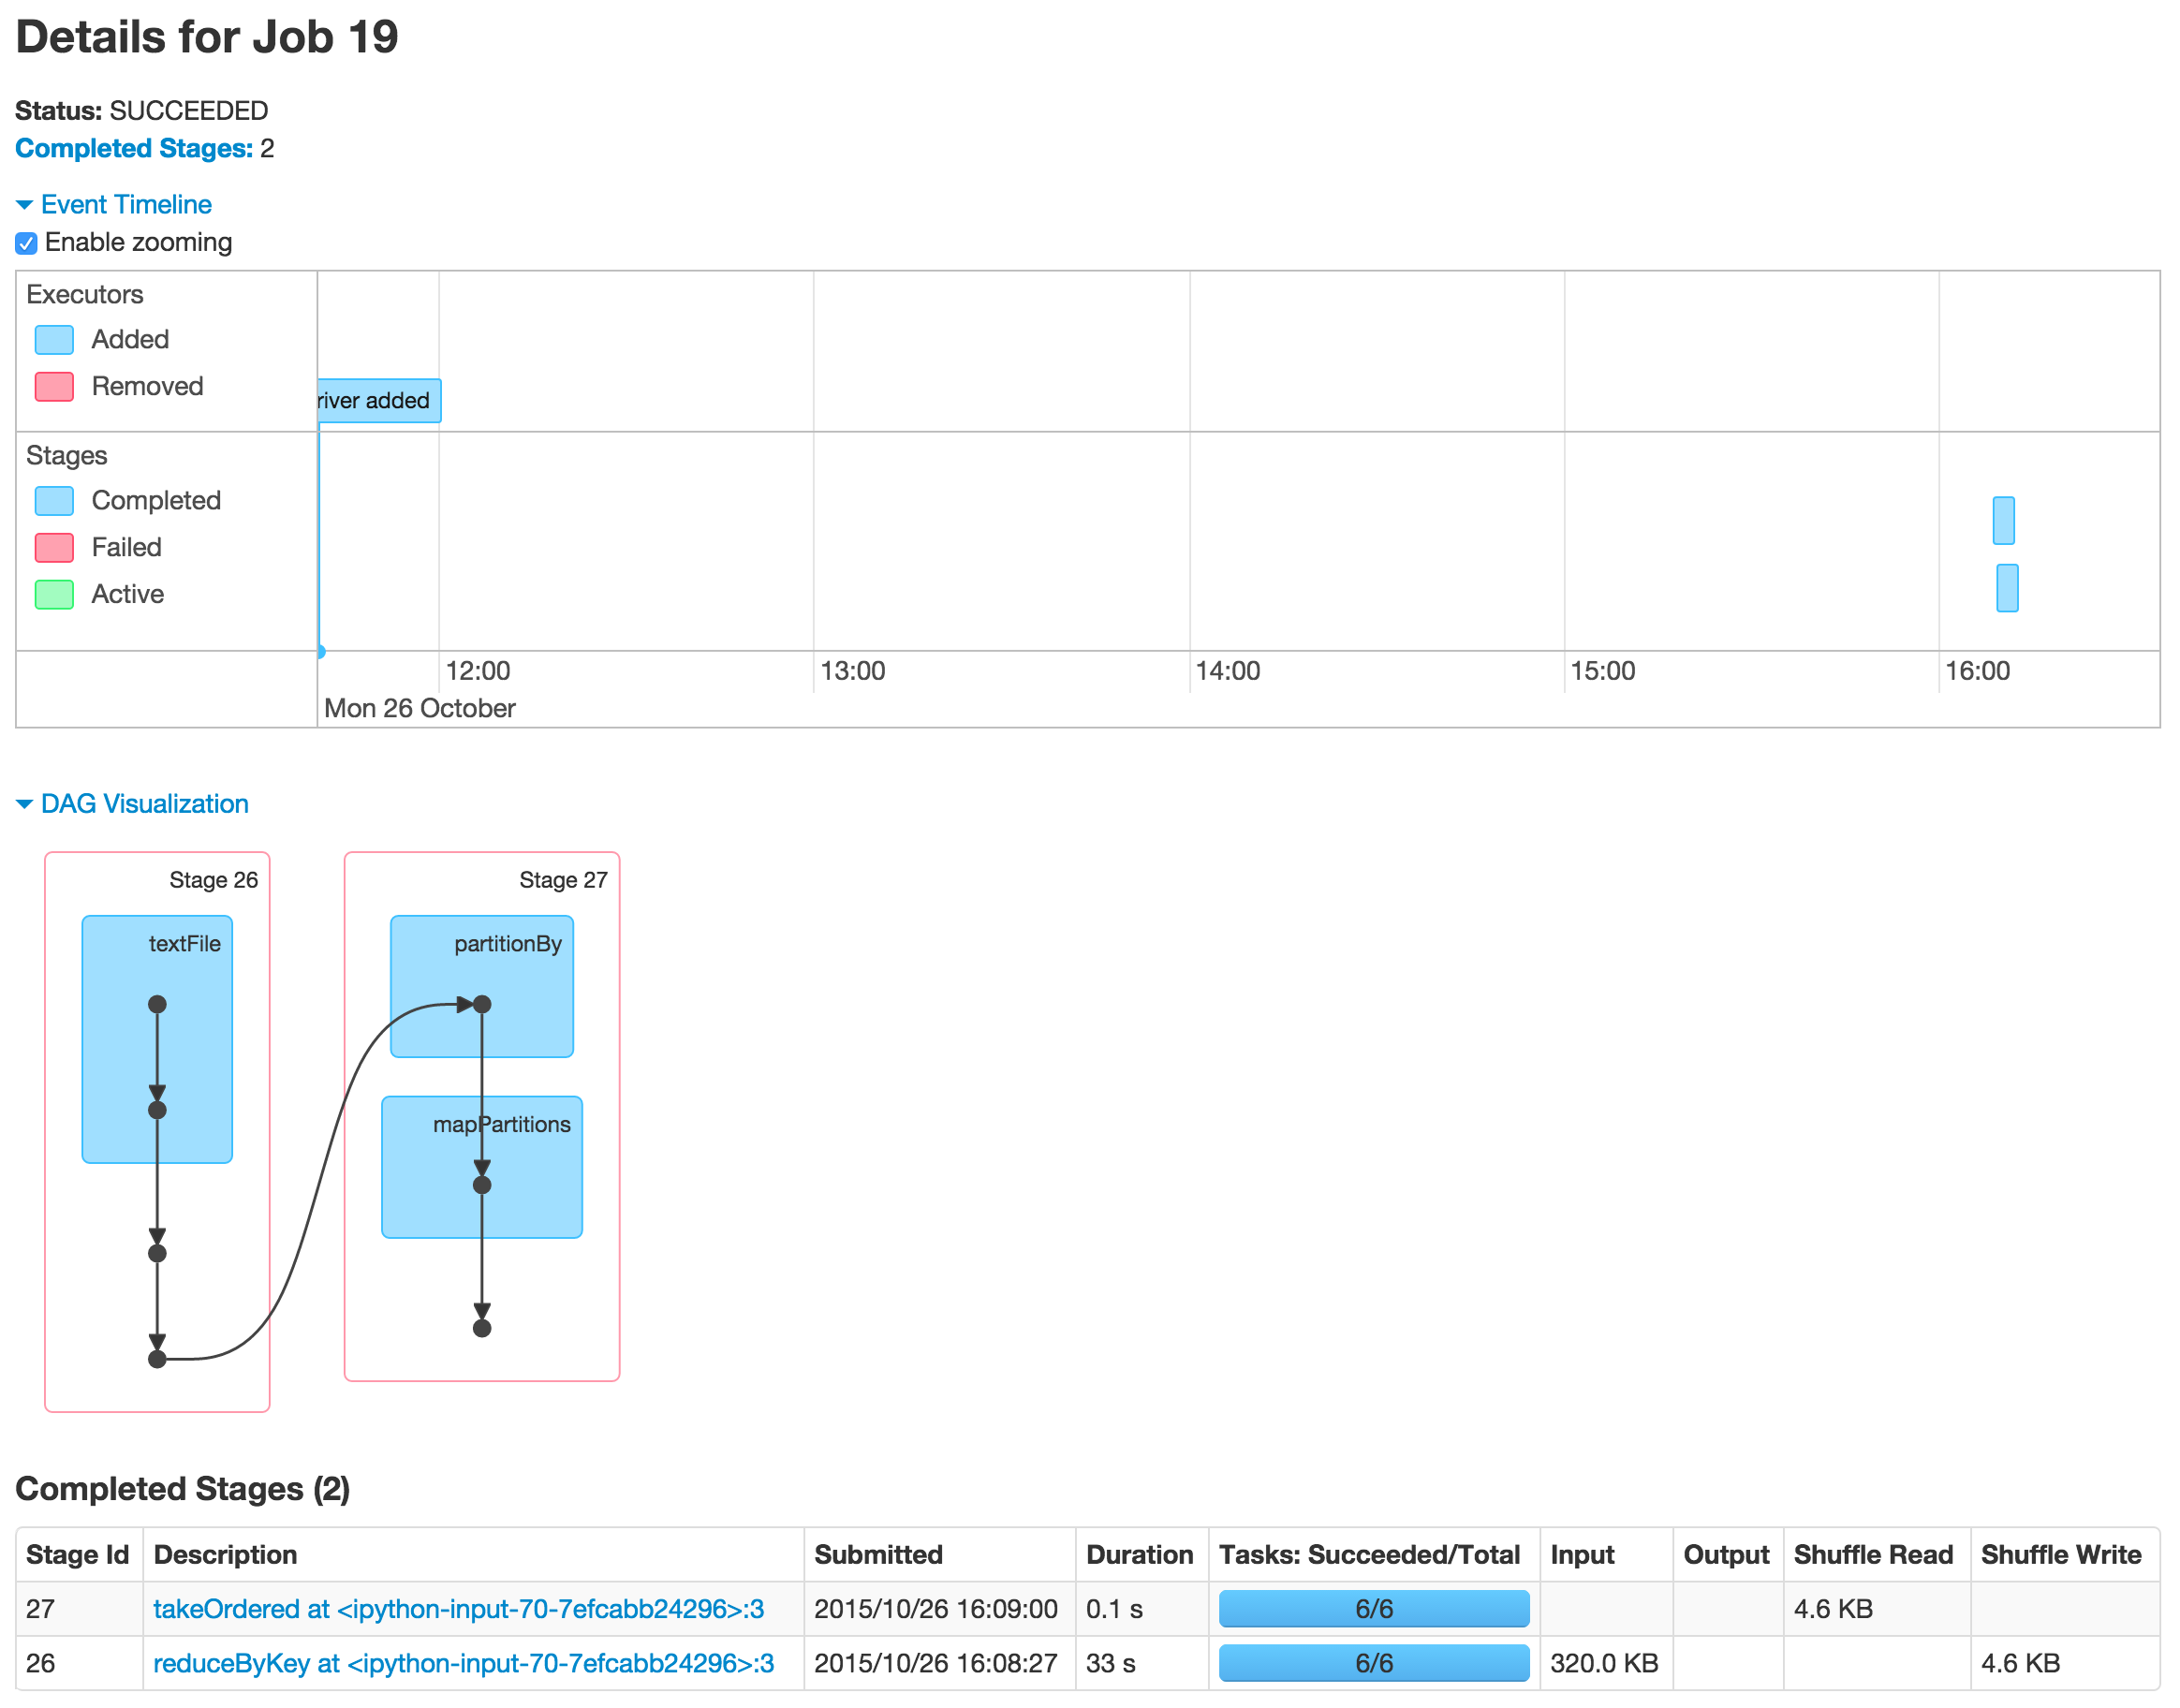

In [76]:
from IPython.display import Image
Image("ui-job.png")

This shows us the several stages that went into the job in the timeline at top - the two skinny blue blobs at far right are the completed stages, one after the other.  You can see them spelled out in detail in the "Completed Stages" table at the bottom.  ```reduceByKey``` came first, and took 33 seconds, with six tasks.  You can see how the stages flowed with the data partitioning across cores in the "DAG Visualization" image in the middle.

Clicking on the timeline's blue blob representing the ```reduceByKey``` stage yields a more detail view of how that stage executed:

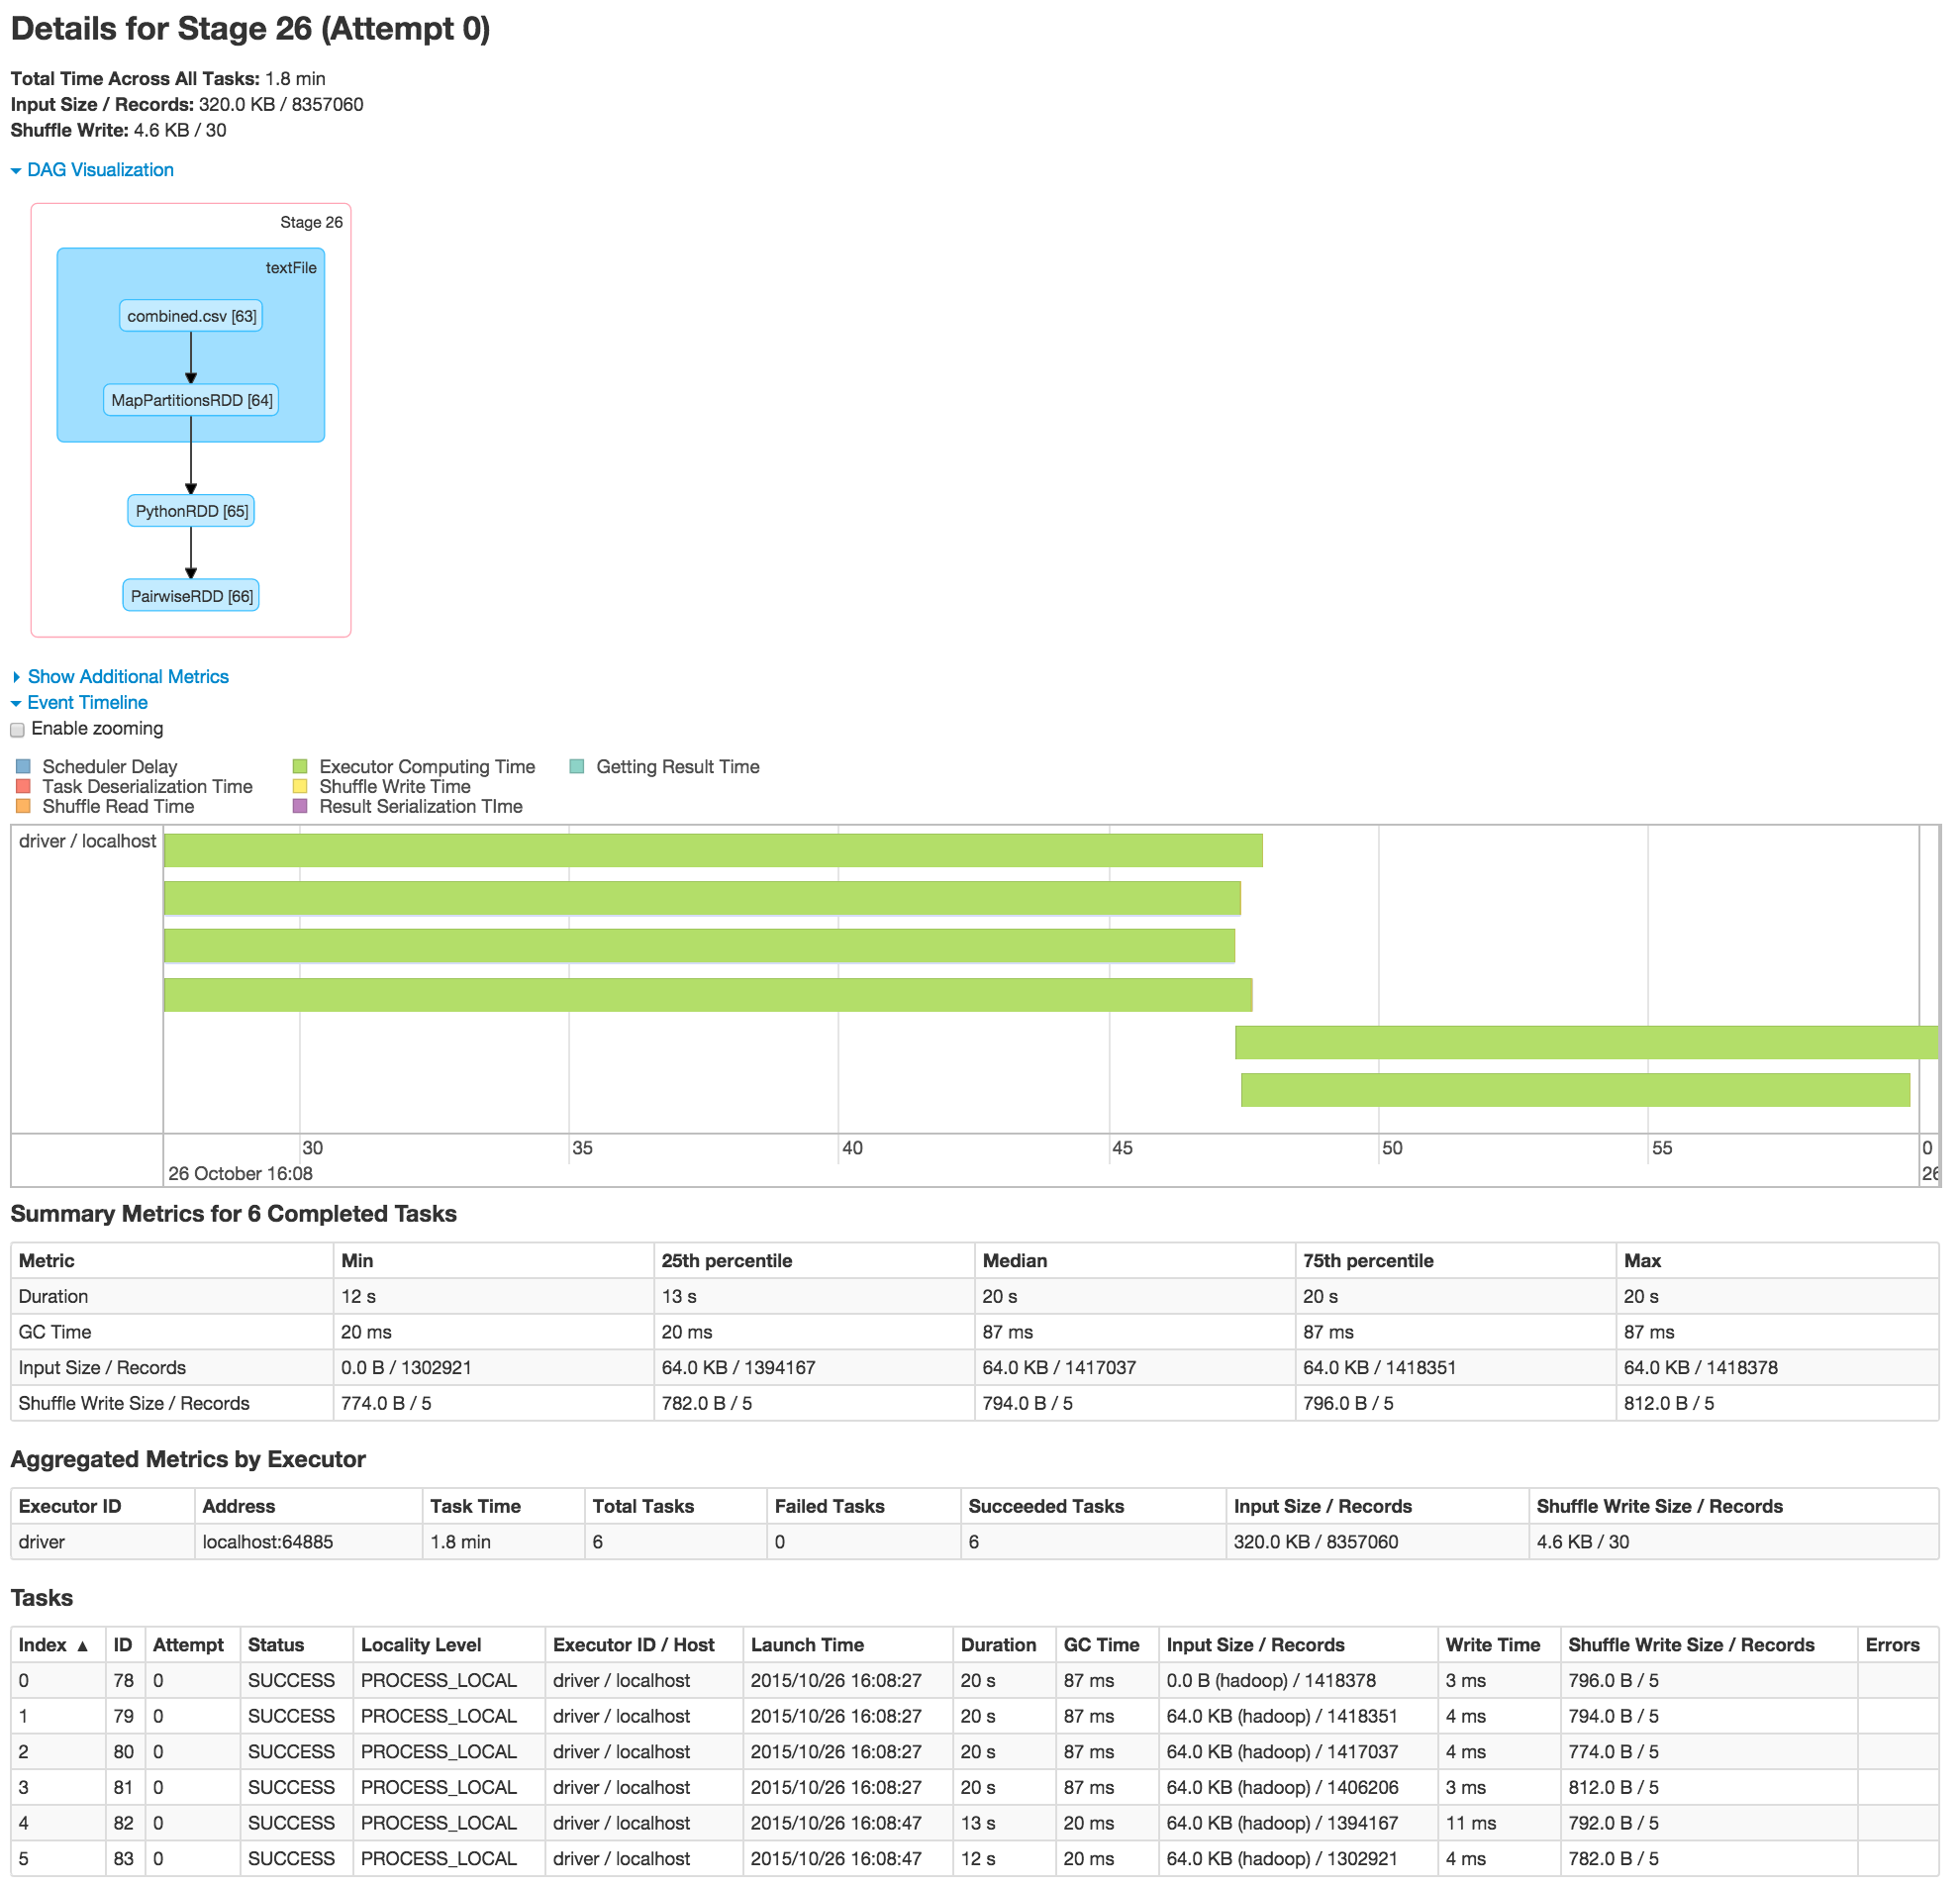

In [78]:
Image("ui-stages.png")

At the individual stage of ```reduceByKey```, we can see the graph of partitioning the data across the four cores, then ultimately moving the data into the pair RDD (the tuples with the counts that got added up).  The timeline below shows those reduce jobs occuring across the cores, with the data partitioned into four jobs over approximately 1,400,000 records and then another two tasks across approximately 1,300,000 records, each of which starts (look close at the green bars) as soon as the first and second of the earlier tasks complete.  If this laptop had six cores or more, we can imagine that Spark would have executed them all simulaneously.

It is certainly possible that a decent RDBMS with appropriate indexes would have returned the same result in subsecond time, or far less than 33 seconds, in any case.  On the other hand, if we had 80,000,000 million records, or 8,000,000,000, and enough cores, Spark could blow away the database past a certain threshhold we'd cross in between there somewhere.

## Counting tag/indicator/subfield co-occurences

We can repeat this process to count co-occurences of tags with indicators and subfields.  Let's see how many of each we have, but first, let's parameterize the field extractor piece so our function is more general.  While we're at it let's make the 25 item limit a parameter as well.

In [130]:
def counter(subjects_rdd, splitter, limit=25):
    pairs = subjects_rdd.map(lambda l: l.split(',')).map(splitter)
    return pairs.reduceByKey(add).takeOrdered(limit, key=lambda (k, v): -v)  

splitter = lambda l: (l[1], 1)
counter(subjects_sample, splitter, 10)

[(u'650', 66131),
 (u'651', 13067),
 (u'600', 6330),
 (u'655', 5630),
 (u'653', 3700),
 (u'648', 2430),
 (u'610', 1647),
 (u'630', 638),
 (u'611', 424),
 (u'654', 2)]

It works - so now we can vary the columns it's using to count things up just by passing in a different splitter.  Let's look at just tag + indicator combinations first.

In [133]:
counter(subjects_sample, lambda l: ((l[1], l[2], l[3]), 1), 5)

[((u'650', u' ', u'7'), 24510),
 ((u'650', u' ', u'0'), 19411),
 ((u'650', u'0', u'7'), 8024),
 ((u'651', u' ', u'7'), 8013),
 ((u'650', u' ', u'6'), 5503)]

It seems to be working just fine, so let's run it over the full dataset, pulling out the top combinations.

In [140]:
top_subjects_indicators = counter(subjects_all, lambda l: ((l[1], l[2], l[3]), 1))

Let's take a better look at that using matplotlib.

In [88]:
%matplotlib inline

In [141]:
top = [("%s-%s-%s" % (k[0], '_' if k[1] == ' ' else k[1], '_' if k[2] == ' ' else k[2]), v) 
         for k, v in top_subjects_indicators]

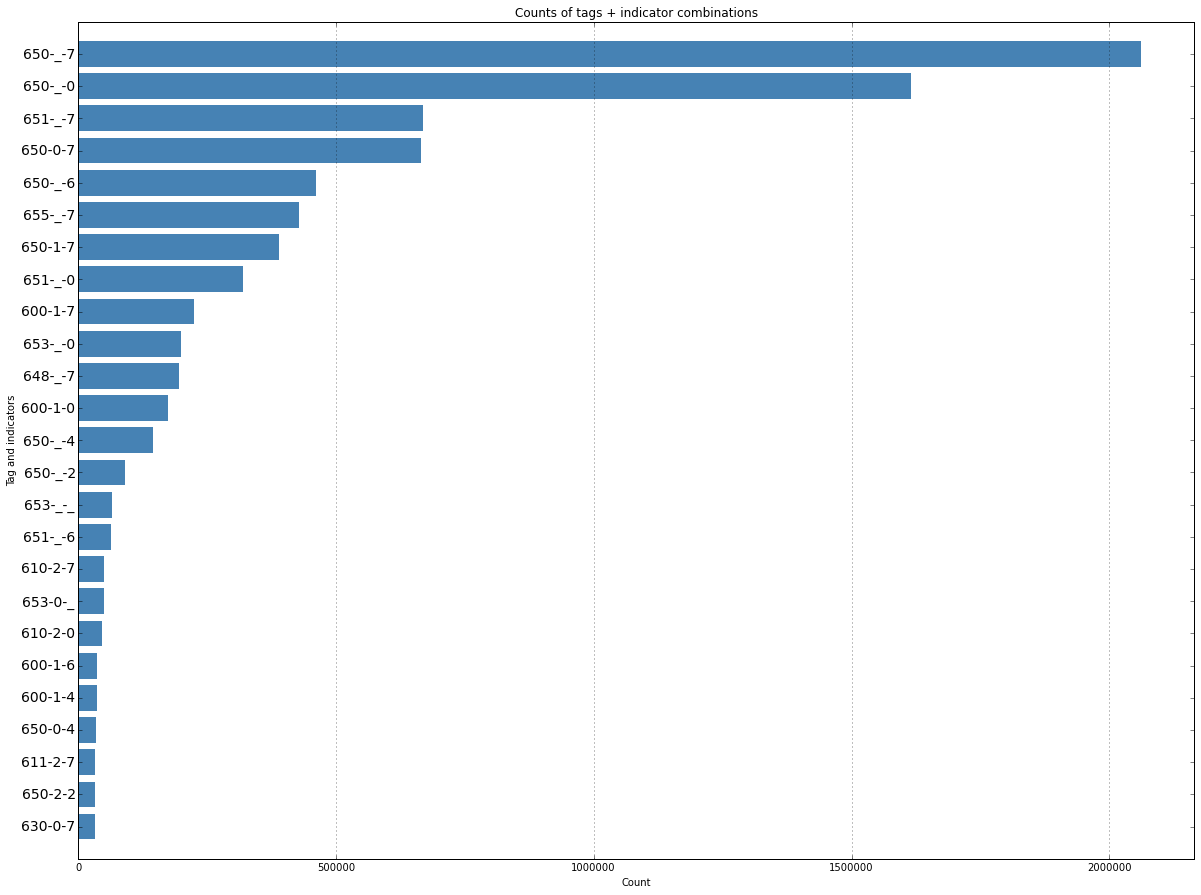

In [163]:
import matplotlib.pyplot as plt
import numpy as np

y_pos = np.arange(len(top))

plt.barh(y_pos, [v for k, v in reversed(top)], 
         align='center', color='steelblue', edgecolor='none')
plt.xlabel('Count')
plt.xlim([0, top[0][1] * 1.05])
plt.gca().xaxis.grid(True)
plt.ylabel('Tag and indicators')
plt.yticks(y_pos, [k for k, v in reversed(top)])
plt.ylim([-1, 25])
plt.tick_params(axis='y', labelsize=14)
plt.title('Counts of tags + indicator combinations')
plt.show()

Let's go a little further and add the subfields to the mix.

In [164]:
top_subfields = counter(subjects_all, lambda l: ((l[1], l[2], l[3], l[4]), 1))

In [166]:
top = [("%s-%s-%s-%s" % (k[0], '_' if k[1] == ' ' else k[1], '_' if k[2] == ' ' else k[2], k[3]), v) 
       for k, v in top_subfields]

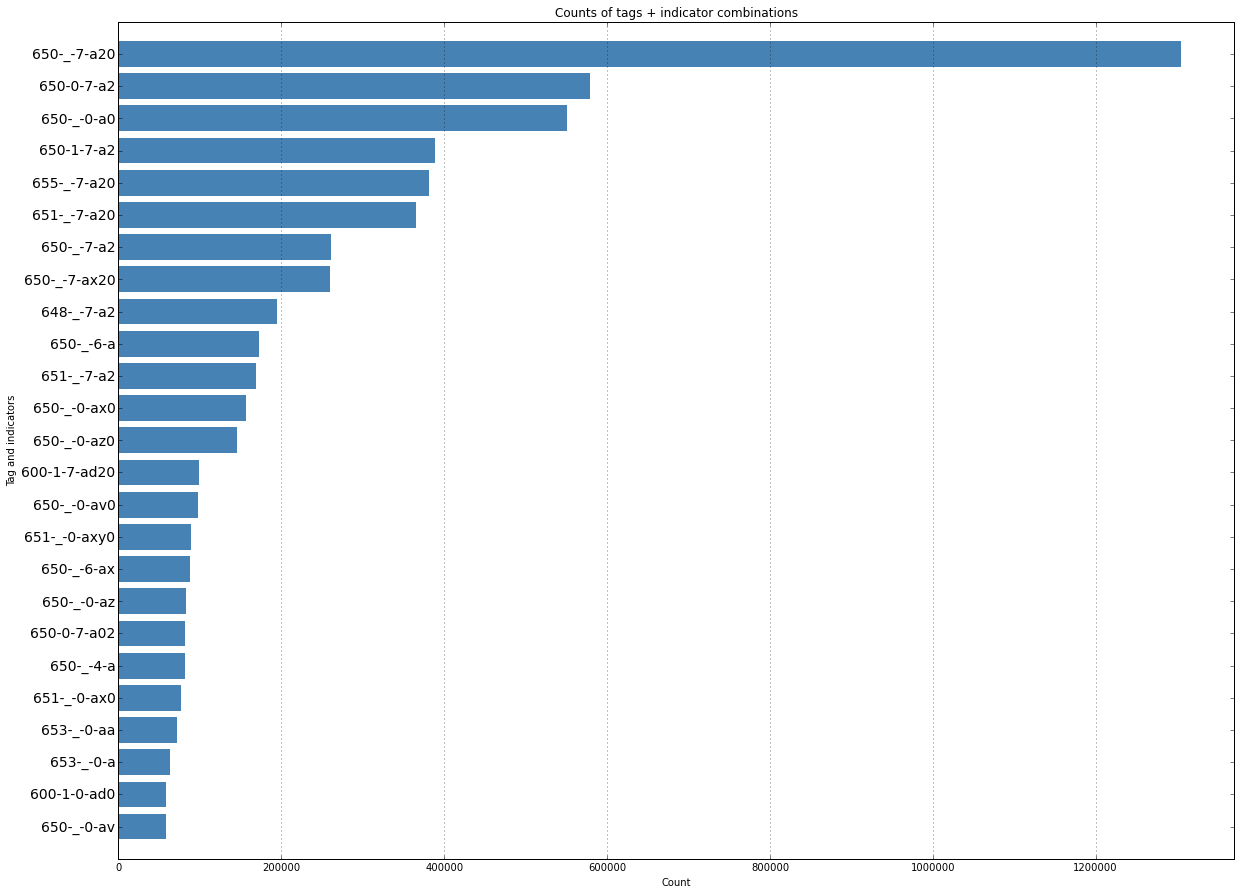

In [171]:
y_pos = np.arange(len(top_subf))

plt.barh(y_pos, [v for k, v in reversed(top)], 
         align='center', color='steelblue', edgecolor='none')
plt.xlabel('Count')
plt.xlim([0, top[0][1] * 1.05])
plt.gca().xaxis.grid(True)
plt.ylabel('Tag and indicators')
plt.yticks(y_pos, [k for k, v in reversed(top)])
plt.ylim([-1, 25])
plt.tick_params(axis='y', labelsize=14)
plt.title('Counts of tags + indicator combinations')
plt.show()

This would look a lot better with the y-tick labels aligned to the left, but I couldn't quite get that right without some awkward code.  (Oh well... not the main point here.)

We can see from this plot that the tag+indicator+subfield combo that occurred the most, in more than 1 out of every 8 subjects, more than twice any other combo, was a 650 with blank first indicator and second indicator 7. According to the [LC Concise MARC Bibliographic definition for 650](https://www.loc.gov/marc/bibliographic/bd650.html) this indicates that the source of the term is specified in subfield 2.  Looking a few ticks further down, we see that the 2nd, 4th, 5th, 6th, 7th, 8th, and 9th highest patterns also included indicator 7, which holds the same meaning for topic and geographic (651) added entries, as well as genre/form (655) and chronological added entries (648). 

So let's carry on and count the subfield 2 values.

In [173]:
sf2 = counter(subjects_all, lambda l: (l[5], 1))
sf2

[(u'', 3569520),
 (u'fast', 2787818),
 (u'swd', 859829),
 (u'gtt', 391158),
 (u'ram', 247510),
 (u'gnd', 197176),
 (u'eclas', 65446),
 (u'idszbz', 44423),
 (u'larpcal', 39849),
 (u'unbist', 17415),
 (u'rasuqam', 15941),
 (u'lcgft', 15100),
 (u'bisacsh', 13138),
 (u'idsbb', 10911),
 (u'gsafd', 10143),
 (u'sears', 6899),
 (u'fssh', 6561),
 (u'stw', 6301),
 (u'rero', 6229),
 (u'renib', 5854),
 (u'embne', 3911),
 (u'fmesh', 3370),
 (u'bidex', 3255),
 (u'idszbzna', 3241),
 (u'local', 2644)]

I'll leave scraping [LC's Subject Heading and Source Term Codes](http://www.loc.gov/standards/sourcelist/subject.html) and mapping the ```dl``` element values to a table we can cross-reference as an exercise for the reader. :)

But we can see that nearly half of the subjects did not reference a source, more than a quarter referenced [OCLC's FAST](http://fast.oclc.org/), and quite a few came from German (swd, gnd), Dutch (gtt), and French (ram).